In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import math
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import ndcg_score

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Lambda, Activation, Embedding, Input, Dense, Reshape, Flatten, Dropout, Multiply, Concatenate, Dot


%matplotlib inline  

import warnings
warnings.filterwarnings('ignore')

# Test model on Steam Video Games [dataset](https://www.kaggle.com/tamber/

## Data loading and Preprocessing

In [88]:
steam_ratings = pd.read_csv('steam-200k.csv', index_col=None, header=None)
steam_ratings.columns=['user_id', 'game', 'action', 'hours', 'none']
steam_ratings = steam_ratings.drop('none', axis=1)

# Group interations by user_id and game
steam_ratings = steam_ratings.groupby(['user_id', 'game'])\
                                      .sum()['hours'].reset_index()

steam_ratings['view'] = 1 
steam_ratings

,user_id,game,hours,view
0,5250,Alien Swarm,5.9,1
1,5250,Cities Skylines,145.0,1
2,5250,Counter-Strike,1.0,1
3,5250,Counter-Strike Source,1.0,1
4,5250,Day of Defeat,1.0,1
...,...,...,...,...
128799,309626088,Age of Empires II HD Edition,7.7,1
128800,309812026,Counter-Strike Nexon Zombies,1.0,1
128801,309812026,Robocraft,1.0,1
128802,309824202,Dota 2,1.7,1


Remove users that had less than 5 interactions

In [89]:
min_interactions = 5
users_interactions_count_df = steam_ratings.groupby('user_id').size()
valid_user_ids = users_interactions_count_df[users_interactions_count_df >= min_interactions].reset_index()[['user_id']]
filtered_ratings = steam_ratings.merge(valid_user_ids, how = 'right', left_on = 'user_id', right_on = 'user_id')
filtered_ratings

,user_id,game,hours,view
0,5250,Alien Swarm,5.9,1
1,5250,Cities Skylines,145.0,1
2,5250,Counter-Strike,1.0,1
3,5250,Counter-Strike Source,1.0,1
4,5250,Day of Defeat,1.0,1
...,...,...,...,...
115134,309404240,AdVenture Capitalist,1.7,1
115135,309404240,Mitos.is The Game,3.2,1
115136,309404240,Team Fortress 2,3.2,1
115137,309404240,Transformice,1.3,1


In [90]:
# Add user ID and item ID fields
filtered_ratings['item_id'] = filtered_ratings['game'].astype('category').cat.codes
filtered_ratings['user_id'] = filtered_ratings['user_id'].astype('category').cat.codes
print("Total users:", filtered_ratings.groupby("user_id").sum("view").shape[0])

filtered_ratings = filtered_ratings[['user_id','item_id','game','hours','view']]
filtered_ratings.head(5)

Total users: 3757


,user_id,item_id,game,hours,view
0,0,226,Alien Swarm,5.9,1
1,0,846,Cities Skylines,145.0,1
2,0,972,Counter-Strike,1.0,1
3,0,978,Counter-Strike Source,1.0,1
4,0,1125,Day of Defeat,1.0,1


Split dataset to 80% Train, 20% Test

In [91]:
# Split dataset in Train/Test
train_df, test_df = train_test_split(filtered_ratings,
                                                 stratify=filtered_ratings['user_id'], 
                                                 test_size=0.2,
                                                 )  
print("Train/test split:", train_df.shape, test_df.shape)
train_df.reset_index(drop=True, inplace=True)
train_df.groupby("user_id").sum('view')

Train/test split: (92111, 5) (23028, 5)


,item_id,hours,view
user_id,,,
0,31586.0,241.5,17
1,73720.0,585.5,29
2,172438.0,319.3,65
3,14643.0,8.0,8
4,14137.0,6.0,6
...,...,...,...
3752,21611.0,7.7,7
3753,23742.0,27.8,11
3754,23184.0,14.1,6


 Create a DataFrame with Content Information

In [92]:
games_df = filtered_ratings.groupby(['game', 'item_id'])\
                                    .agg({'user_id': 'count', 'hours': np.sum})[['user_id','hours']]\
                                    .reset_index()\
                                    .rename(columns={'user_id': 'total_users', 'hours': 'total_hours'})


games_df = games_df[['item_id', 'game','total_users','total_hours']]
games_df      

,item_id,game,total_users,total_hours
0,0,007 Legends,1,1.7
1,1,0RBITALIS,3,4.2
2,2,1... 2... 3... KICK IT! (Drop That Beat Like a...,7,27.0
3,3,10 Second Ninja,6,11.9
4,4,"10,000,000",1,4.6
...,...,...,...,...
5108,5108,sZone-Online,95,147.7
5109,5109,samurai_jazz,1,1.0
5110,5110,the static speaks my name,13,15.0
5111,5111,theHunter,220,515.3


### Create a Matrix of Interactions

In [93]:
# Create a user-item matrix
# For this dataset, we train a U-AutoRec since we only have item properties.

users_items_matrix_train = train_df.pivot(index='user_id', columns='item_id', values='view').fillna(0)
users_items_matrix_test  = test_df.pivot(index='user_id', columns='item_id', values='view').fillna(0)

print("Train set - users,items = ", users_items_matrix_train.shape)
print("Test set - users,items = ", users_items_matrix_test.shape)

Train set - users,items =  (3757, 4857)
Test set - users,items =  (3757, 3230)


In [94]:
# Extend test set to account missing items, set default rating to 0
for i in range(users_items_matrix_train.shape[1] - users_items_matrix_test.shape[1]):
  users_items_matrix_test[users_items_matrix_test.shape[1] + users_items_matrix_test.shape[1]] = 0

print("Train set - users,items = ", users_items_matrix_train.shape)
print("Test set - users,items = ", users_items_matrix_test.shape)

Train set - users,items =  (3757, 4857)
Test set - users,items =  (3757, 4857)


In [95]:
users_items_matrix_train.head(10)

item_id,0,1,2,3,4,5,6,7,8,9,...,5100,5101,5102,5104,5105,5106,5108,5110,5111,5112
user_id,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Create a Input Content

In [96]:
def split_str(val):
    tokens = []
    for v in val:
        tokens.extend(v.split(' '))
    return " ".join(tokens)

In [97]:
# Group games per user
user_games = train_df.groupby('user_id')['game'].apply(list).reset_index()
user_games.head()

# Split games names
user_games['tokens'] = user_games['game'].apply(split_str)
user_games.head(2)

,user_id,game,tokens
0,0,"[Cities Skylines, Day of Defeat, Portal, Deus ...",Cities Skylines Day of Defeat Portal Deus Ex H...
1,1,"[Arma 2, Age of Empires II HD Edition, Thief -...",Arma 2 Age of Empires II HD Edition Thief - Pr...


In [98]:
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences

Using TensorFlow backend.


ImportError: cannot import name 'transpose_shape' from 'keras.utils.generic_utils' (/home/sr-gpu/.local/lib/python3.8/site-packages/keras/utils/generic_utils.py)

In [99]:
# integer encode the documents
vocab_size   = 100
encoded_docs = [one_hot(d, vocab_size) for d in user_games.tokens]
print(encoded_docs[:2])

[[63, 55, 84, 94, 62, 15, 80, 49, 92, 99, 14, 67, 15, 12, 98, 99, 12, 9, 97, 98, 99, 12, 32, 14, 67, 54, 98, 99, 12, 72, 12, 98, 99, 12, 44, 79, 32, 95, 74, 29, 95, 98, 99, 30, 37, 98, 99, 12, 44, 1, 98, 99, 81, 93], [79, 12, 78, 94, 56, 51, 5, 18, 23, 15, 59, 91, 71, 14, 67, 54, 48, 94, 28, 59, 80, 12, 74, 29, 95, 5, 87, 79, 12, 35, 99, 9, 97, 14, 67, 46, 30, 48, 94, 28, 59, 80, 12, 68, 23, 17, 98, 99, 30, 37, 48, 94, 28, 59, 80, 50, 23, 59, 92, 7, 73, 94, 89, 19, 18, 23, 61, 98, 99, 56, 20, 6, 23, 82, 15, 12, 98, 99, 81, 93, 48, 94, 28, 59, 80, 50, 68, 55, 84, 94, 62, 23, 12, 77, 23, 71, 90]]


In [100]:
# pad documents to a max length of 4 words
max_length  = 50
padded_docs = pad_sequences(encoded_docs, maxlen=max_length, padding='post')
padded_docs

array([[62, 15, 80, ..., 99, 81, 93],
       [99, 30, 37, ..., 23, 71, 90],
       [78, 94, 56, ..., 12, 11, 87],
       ...,
       [ 4, 47, 39, ...,  0,  0,  0],
       [60, 51, 28, ...,  0,  0,  0],
       [49, 74, 29, ...,  0,  0,  0]], dtype=int32)

## Model building

In [101]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping


class BaseModel(object):
  WEIGHT_MODEL       = "weights-best-model.hdf5"

  def callbacks_list(self, monitor='val_loss', path_model = WEIGHT_MODEL, patience=15):
    checkpoint = ModelCheckpoint(path_model, monitor=monitor, verbose=1, save_best_only=True, mode='min')
    early_stop = EarlyStopping(monitor=monitor,min_delta=0, patience=patience, verbose=0, mode='auto')

    callbacks_list = [checkpoint, early_stop]
    return callbacks_list    

In [102]:
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.layers import Input, Dense, Embedding, Flatten, Dropout, Activation
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras import backend as K
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras import initializers
from tensorflow.keras.layers import add
import numpy as np
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.preprocessing.sequence import pad_sequences

class AutoEncContentModel(BaseModel):
  def __init__(self, layers = [], epochs = None, batch = None, 
                      activation = None, dropout = None, lr = None, reg = None):
    self.layers  = layers
    self.epochs  = epochs
    self.batch   = batch
    self.activation = activation
    self.dropout = dropout
    self.lr      = lr
    self.reg     = reg
    self.model   = None
        

  def data_preparation(self, interactions, user_item_matrix):
    '''
    Create a Input to Model
    '''

    # Params
    #   integer encode the documents
    vocab_size   = 100
    #   pad documents to a max length of 4 words
    max_length   = 50


    def split_str(val):
      '''
      Split and Join Array(Array(str))
      '''
      tokens = []
      for v in val:
          tokens.extend(v.split(' '))
      return ' '.join(tokens)

    #  Order users in matrix interactions
    users_ids  = list(user_item_matrix.index)
    
    # Dataset with User X Content information
    user_games = interactions.groupby('user_id')['game'].apply(list).loc[users_ids].reset_index()
    user_games['tokens'] = user_games['game'].apply(split_str)

    # Prepare input layer
    encoded_tokens = [one_hot(d, vocab_size) for d in user_games.tokens]
    padded_tokens  = pad_sequences(encoded_tokens, maxlen=max_length, padding='post')

    # Input  
    X = [user_item_matrix.values, padded_tokens]
    y = user_item_matrix.values

    return X, y


  def compute_masked_loss(self, y_true, y_pred):
      """
      Compute loss between y_true(The true output) and y_pred(The predicted output)
      """
      # ignore the missing value (having value of zero) in loss computation
      mask_true = tf.cast(tf.not_equal(y_true, 0), dtype='float32') 

      error = y_true - y_pred

      se = tf.square(error) * mask_true
      mse = tf.reduce_sum(se) / tf.reduce_sum(mask_true)
      return mse 

  def masked_rmse_loss(self, y_true, y_pred):
      return tf.math.sqrt(self.compute_masked_loss(y_true, y_pred))

  def fit(self, X, y, verbose=1):
    '''
    Train Model
    '''

    # Build model
    model = self.build_model(X)

    model.compile(optimizer = Adam(lr=self.lr), 
                    loss=self.compute_masked_loss, metrics=[self.masked_rmse_loss])

    # train
    hist = model.fit(x=X, y=y,
                      epochs=self.epochs,
                      batch_size=self.batch,
                      shuffle=True,
                      validation_split=0.1,
                      callbacks=self.callbacks_list(), verbose=verbose)

    model.load_weights(self.WEIGHT_MODEL)
    self.model = model
    self.history = hist

    return model, hist

  def plot_loss_history(self):
    plt.plot(self.history.history['loss'])
    plt.plot(self.history.history['val_loss'])
    plt.title('Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['loss', 'val_loss'], loc='upper left')
    plt.show()


  def predict(self, X):

    # Predict
    pred = self.model.predict(X)

    # remove watched items from predictions
    pred = pred * (X[0] == 0) 

    return pred

  def build_model(self, X):
    '''
    Autoencoder for Collaborative Filter Model
    '''

    # Params
    users_items_matrix, content_info = X

    # Input
    input_layer   = x = Input(shape=(users_items_matrix.shape[1],), name='UserScore')
    input_content = Input(shape=(content_info.shape[1],), name='Itemcontent')

    # Encoder
    k = int(len(self.layers)/2)
    i = 0
    for l in self.layers[:k]:
      x = Dense(l, activation=self.activation, 
                      name='EncLayer{}'.format(i))(x)
      i = i+1

    # Latent Space
    x = Dense(self.layers[k], activation=self.activation, 
                                name='UserLatentSpace')(x)

    # Content Information
    x_content = Embedding(100, self.layers[k], 
                        input_length=content_info.shape[1])(input_content)
    x_content = Flatten()(x_content)
    x_content = Dense(self.layers[k], activation=self.activation, 
                                name='ItemLatentSpace')(x_content)
    # Concatenate
    x = add([x, x_content], name='LatentSpace')

    # Dropout
    x = Dropout(self.dropout)(x)

    # Decoder
    for l in self.layers[k+1:]:
      i = i-1
      x = Dense(l, activation=self.activation, 
                      name='DecLayer{}'.format(i))(x)

    # Output
    output_layer = Dense(users_items_matrix.shape[1], activation='linear', name='UserScorePred')(x)


    # this model maps an input to its reconstruction
    model = Model([input_layer, input_content], output_layer)

    return model

## Model Fitting

In [103]:
# Hyperparameters
layers = [128, 256, 512]
epochs = 10
batch = 128
activation = 'sigmoid'         #['relu', 'elu', 'selu', 'sigmoid']
dropout = 0.6
lr = 0.001
reg = 0.001

In [104]:
# Build model
autoenc_model = AutoEncContentModel(layers, epochs, batch, activation, dropout, lr, reg)
# ---------------------------------------------
# Input - Prepare input layer
X, y  = autoenc_model.data_preparation(train_df, users_items_matrix_train)

# Train
model, hist = autoenc_model.fit(X, y)
model.summary()

Epoch 1/10
27/27 [==============================] - 1s 10ms/step - loss: 0.1737 - masked_rmse_loss: 0.3656 - val_loss: 0.0216 - val_masked_rmse_loss: 0.1466

Epoch 00001: val_loss improved from inf to 0.02158, saving model to weights-best-model.hdf5
Epoch 2/10
27/27 [==============================] - 0s 8ms/step - loss: 0.0115 - masked_rmse_loss: 0.1054 - val_loss: 0.0110 - val_masked_rmse_loss: 0.1040

Epoch 00002: val_loss improved from 0.02158 to 0.01103, saving model to weights-best-model.hdf5
Epoch 3/10
27/27 [==============================] - 0s 9ms/step - loss: 0.0054 - masked_rmse_loss: 0.0731 - val_loss: 0.0091 - val_masked_rmse_loss: 0.0944

Epoch 00003: val_loss improved from 0.01103 to 0.00914, saving model to weights-best-model.hdf5
Epoch 4/10
27/27 [==============================] - 0s 7ms/step - loss: 0.0040 - masked_rmse_loss: 0.0632 - val_loss: 0.0081 - val_masked_rmse_loss: 0.0886

Epoch 00004: val_loss improved from 0.00914 to 0.00809, saving model to weights-best-mo

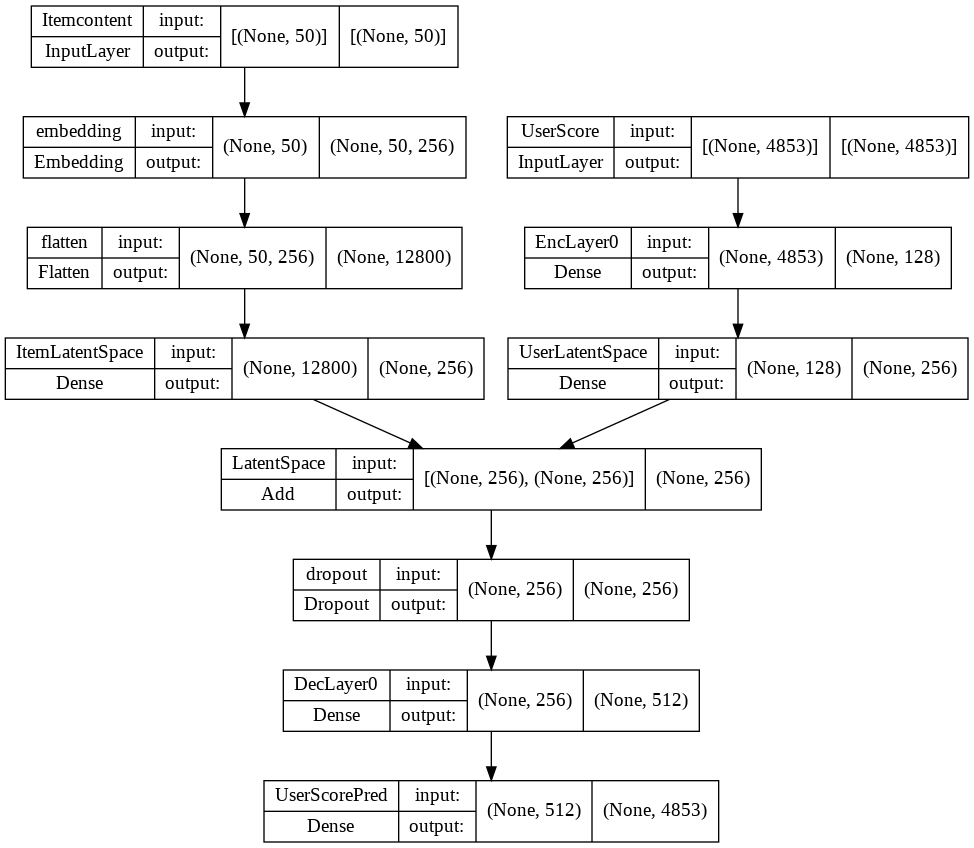

In [27]:
keras.utils.plot_model(model, show_shapes=True)

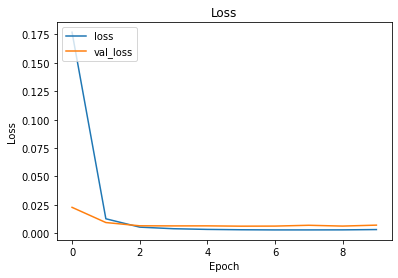

In [55]:
autoenc_model.plot_loss_history()

In [105]:
print("Model RMSE on train:", autoenc_model.history.history['masked_rmse_loss'][-1])
print("Model RMSE on validation:", autoenc_model.history.history['val_masked_rmse_loss'][-1])

Model RMSE on train: 0.05689087137579918
Model RMSE on validation: 0.0961882546544075


## Model Evaluation on test set



In [106]:
X_test, y_test  = autoenc_model.data_preparation(test_df, users_items_matrix_test)
print(X_test[0].shape, X_test[1].shape, y_test.shape)
test_rmse = model.evaluate(X_test, y_test)[1]
print("Model RMSE on test set:", test_rmse)

(3757, 4857) (3757, 50) (3757, 4857)
118/118 [==============================] - 0s 1ms/step - loss: 0.0072 - masked_rmse_loss: 0.0817
Model RMSE on test set: 0.08171898871660233


In [59]:
# Predict new Matrix Interactions, set score zero on visualized games
predicted_test = model.predict(X_test) * (X_test[0] == 0)

In [60]:
predicted_test

array([[0.92776424, 1.0502156 , 0.9587581 , ..., 0.9912087 , 0.9830445 ,
        1.0541272 ],
       [0.9243959 , 1.0470518 , 0.95303214, ..., 0.9870202 , 0.98227173,
        1.0516173 ],
       [0.91410595, 1.0371462 , 0.93205607, ..., 0.96879464, 0.9709455 ,
        1.0394546 ],
       ...,
       [0.9229688 , 1.0453271 , 0.9486071 , ..., 0.9829616 , 0.9780255 ,
        1.0475434 ],
       [0.92351216, 1.0459615 , 0.94938546, ..., 0.98358864, 0.9783038 ,
        1.0479836 ],
       [0.92583454, 1.0482444 , 0.95390964, ..., 0.9873502 , 0.98046297,
        1.0508267 ]], dtype=float32)

In [61]:
# converting the reconstructed matrix back to a Pandas dataframe
predicted_users_items_matrix = pd.DataFrame(predicted_test, 
                                          columns = users_items_matrix_test.columns, 
                                          index   = users_items_matrix_test.index)
predicted_users_items_matrix.head()

item_id,2,3,5,6,7,8,9,10,12,13,14,16,19,21,22,23,24,25,26,27,28,29,30,31,35,36,38,39,44,45,47,48,51,52,53,57,59,60,61,62,...,9626,9628,9630,9632,9634,9636,9638,9640,9642,9644,9646,9648,9650,9652,9654,9656,9658,9660,9662,9664,9666,9668,9670,9672,9674,9676,9678,9680,9682,9684,9686,9688,9690,9692,9694,9696,9698,9700,9702,9704
user_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0.927764,1.050216,0.958758,0.987254,0.955157,0.926381,0.941446,1.025791,1.019737,1.014245,1.022758,1.169381,1.015265,0.977669,0.990057,0.976444,1.054010,1.002969,0.972085,1.005751,1.085900,1.151219,0.978320,0.900567,1.017312,1.172406,0.996391,1.065961,1.130077,1.001131,0.869063,0.990930,0.930400,1.050629,0.994277,1.044856,-0.050224,1.017572,0.989605,0.983671,...,0.956288,0.808496,1.111012,1.015892,0.986194,0.988156,1.016201,1.015155,1.036307,0.952423,1.202374,0.979591,0.747436,1.213020,1.169414,1.027662,0.937783,0.949462,0.990186,1.001271,0.965187,0.872155,0.977719,0.971915,1.000601,1.053965,0.133448,0.903565,0.857393,1.042702,1.051690,1.072167,0.876584,0.989459,1.137278,0.989950,0.249123,0.991209,0.983045,1.054127
1,0.924396,1.047052,0.953032,0.981666,0.950446,0.924505,0.936499,1.022768,1.016094,1.011029,1.017512,1.164794,1.009426,0.974993,0.986512,0.973870,1.050616,1.001097,0.967820,1.003782,1.083359,1.148043,0.975410,0.896839,1.013402,1.169604,0.994358,1.062085,1.122902,0.997341,0.867156,0.988398,0.929183,1.049054,0.991272,1.039586,-0.049691,1.014963,0.989058,0.980279,...,0.951608,0.805452,1.107897,1.009832,0.982365,0.986821,1.013000,1.009574,1.033265,0.950602,1.198155,0.973210,0.744880,1.209344,1.165563,1.023173,0.936274,0.942125,0.986702,0.998452,0.960247,0.868786,0.973190,0.970588,0.996302,1.051544,0.133410,0.900882,0.857983,1.040450,1.049628,1.066976,0.871990,0.983425,1.133886,0.984712,0.248440,0.987020,0.982272,1.051617
2,0.914106,1.037146,0.932056,0.962204,0.931833,0.912215,0.918417,1.006115,0.998659,0.997509,0.993660,1.143093,0.994759,0.958433,0.972776,0.957486,1.033562,0.989510,0.950486,0.992884,1.068309,1.136460,0.962373,0.875878,0.999131,1.153797,0.983267,1.043265,1.100025,0.981486,0.854636,0.978669,0.918458,1.039885,0.981284,1.017017,-0.045893,0.999801,0.981895,0.961992,...,0.935764,0.792829,1.097207,0.987028,0.968660,0.979105,0.998271,0.993108,1.014002,0.943860,1.177677,0.947763,0.733083,1.192194,1.149241,1.008462,0.927929,0.920986,0.976234,0.984470,0.938170,0.852324,0.953319,0.961770,0.981321,1.037935,0.135402,0.889814,0.855542,1.025215,1.033208,1.048156,0.857209,0.959135,1.116616,0.969218,0.240347,0.968795,0.970945,1.039455
3,0.924842,1.047369,0.951936,0.980853,0.949314,0.921247,0.936248,1.021360,1.014457,1.009832,1.015600,1.164068,1.008858,0.972811,0.985832,0.972523,1.048627,0.999775,0.967465,1.002631,1.082270,1.146972,0.974879,0.895071,1.012656,1.167805,0.992631,1.060717,1.123078,0.996161,0.865605,0.987952,0.926658,1.047927,0.991132,1.038124,-0.049398,1.012679,0.987415,0.978871,...,0.951368,0.805003,1.106999,1.009061,0.981752,0.986503,1.012256,1.009733,1.030403,0.949722,1.195667,0.971101,0.744213,1.208350,1.165162,1.022479,0.935783,0.942555,0.986828,0.998087,0.959345,0.867871,0.971040,0.969762,0.995418,1.050069,0.133466,0.900474,0.856425,1.038848,1.047784,1.066240,0.871745,0.982405,1.132379,0.985037,0.247169,0.985993,0.979335,1.049911
4,0.924053,1.046697,0.951801,0.980270,0.948741,0.921355,0.935078,1.020685,1.013510,1.009561,1.015264,1.162634,1.008995,0.972295,0.984940,0.971731,1.048319,0.999015,0.966429,1.002274,1.081575,1.146006,0.973861,0.894356,1.011762,1.167139,0.991495,1.059796,1.121839,0.995361,0.865115,0.987573,0.926179,1.047601,0.990206,1.036800,-0.048960,1.012236,0.987200,0.978259,...,0.950205,0.804655,1.106584,1.008499,0.981002,0.986213,1.011518,1.008849,1.030281,0.949519,1.194559,0.969725,0.743282,1.207221,1.164692,1.021556,0.935557,0.941560,0.985902,0.997443,0.958304,0.867092,0.969607,0.969093,0.995418,1.049286,0.133259,0.900115,0.856395,1.038481,1.046774,1.065542,0.871345,0.981486,1.131

In [64]:
print("NDCG score:", ndcg_score(users_items_matrix_test, predicted_test))


NDCG score: 0.12635963761223631


# Test data on MovieLens 1M

## Download and load MovieLens 1M dataset

In [107]:
import requests, zipfile, os
url = 'http://files.grouplens.org/datasets/movielens/ml-1m.zip'
zip_name = 'ml-1m.zip'
data_dir = 'ml-1m/'
if not os.path.exists(os.path.join(data_dir, zip_name)):
  r = requests.get(url, allow_redirects=True)
  open(zip_name, 'wb').write(r.content)

  with zipfile.ZipFile(zip_name,"r") as zip_ref:
      zip_ref.extractall()

cols_data = ['user_id','item_id','rating','timestamp']
cols_user = ['user_id','gender', 'age','occupation','zipcode']
cols_item = ['movie_id','movie_title', 'release_date','video_release_date',
             'IMDb_URL','unknown','Action','Adventure','Animation',
             'Childrens','Comedy','Crime','Documentary','Drama','Fantasy','Film_Noir','Horror','Musical','Mystery','Romance',
             'Sci_Fi','Thriller','War','Western']


# loading the data to dataframes
df_users = pd.read_csv(data_dir + 'users.dat',delimiter='::', header=None,names=cols_user)
df_ratings = pd.read_csv(data_dir + 'ratings.dat', delimiter='::', header=None, names=cols_data)

In [108]:
# Age group dictionary retrieved from dataset description
age_group_dict = {
    1:  "Under 18",
    18:  "18-24",
    25:  "25-34",
    35:  "35-44",
    45:  "45-49",
    50:  "50-55",
    56:  "56+"
}

In [109]:
# Occupation dictionary retrieved from dataset description
occupation_dict = {
    0:  "other or not specified",
    1:  "academic/educator",
    2:  "artist",
    3:  "clerical/admin",
    4:  "college/grad student",
    5:  "customer service",
    6:  "doctor/health care",
    7:  "executive/managerial",
    8:  "farmer",
    9:  "homemaker",
    10:  "K-12 student",
    11:  "lawyer",
    12:  "programmer",
    13:  "retired",
    14:  "sales/marketing",
    15:  "scientist",
    16:  "self-employed",
    17:  "technician/engineer",
    18:  "tradesman/craftsman",
    19:  "unemployed",
    20:  "writer"
}

In [110]:
from sklearn.preprocessing import LabelEncoder

In [111]:
gender_encoder = LabelEncoder()

In [112]:
gender_encoder.fit(df_users['gender'])

LabelEncoder()

In [113]:
gender_values = gender_encoder.transform(df_users['gender'])

In [114]:
print("After Encoding:", gender_values[-10:])

After Encoding: [0 1 1 1 0 0 0 0 0 1]


In [115]:
df_users[['occupation', 'age']].values

array([[10,  1],
       [16, 56],
       [15, 25],
       ...,
       [ 1, 56],
       [ 0, 45],
       [ 6, 25]])

In [116]:
df_ratings

,user_id,item_id,rating,timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291
...,...,...,...,...
1000204,6040,1091,1,956716541
1000205,6040,1094,5,956704887
1000206,6040,562,5,956704746
1000207,6040,1096,4,956715648


In [117]:
#Split Train/Test
df_ratings_train, df_ratings_test = train_test_split(df_ratings,
                                                     stratify=df_ratings['user_id'],
                                                     test_size=0.2)

print(df_ratings_train.shape, df_ratings_test.shape)

(800167, 4) (200042, 4)


In [118]:
# Convert to numpy matrix

# We want to train IAutoRec, so we build a movie-user matrix

ratings_train = df_ratings_train.pivot(index='item_id', columns='user_id', values='rating').fillna(0)
ratings_test = df_ratings_test.pivot(index='item_id', columns='user_id', values='rating').fillna(0)


ratings_train = ratings_train.to_numpy()
ratings_test = ratings_test.to_numpy()

print("Train/test:", ratings_train.shape, ratings_test.shape)

Train/test: (3676, 6040) (3459, 6040)


In [119]:
# Hyperparameters
layers = [128, 256, 512]
epochs = 10
batch = 128
activation = 'sigmoid'         #['relu', 'elu', 'selu', 'sigmoid']
dropout = 0.6
lr = 0.001
reg = 0.001

In [120]:
# Build model
autoenc_model = AutoEncContentModel(layers, epochs, batch, activation, dropout, lr, reg)

# Input - We add content information for users
X = [ratings_train, df_users[['occupation', 'age']].values]
y = ratings_train

# Train
model, hist = autoenc_model.fit(X, y)
model.summary()

Epoch 1/10
26/26 [==============================] - 0s 8ms/step - loss: 3.8573 - masked_rmse_loss: 1.7888 - val_loss: 1.3121 - val_masked_rmse_loss: 1.1467

Epoch 00001: val_loss improved from inf to 1.31213, saving model to weights-best-model.hdf5
Epoch 2/10
26/26 [==============================] - 0s 4ms/step - loss: 1.2076 - masked_rmse_loss: 1.0973 - val_loss: 1.2551 - val_masked_rmse_loss: 1.1213

Epoch 00002: val_loss improved from 1.31213 to 1.25514, saving model to weights-best-model.hdf5
Epoch 3/10
26/26 [==============================] - 0s 4ms/step - loss: 1.0804 - masked_rmse_loss: 1.0392 - val_loss: 1.1738 - val_masked_rmse_loss: 1.0845

Epoch 00003: val_loss improved from 1.25514 to 1.17377, saving model to weights-best-model.hdf5
Epoch 4/10
26/26 [==============================] - 0s 4ms/step - loss: 1.0313 - masked_rmse_loss: 1.0154 - val_loss: 1.1351 - val_masked_rmse_loss: 1.0667

Epoch 00004: val_loss improved from 1.17377 to 1.13512, saving model to weights-best-mod

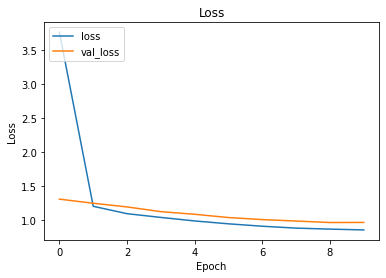

In [81]:
autoenc_model.plot_loss_history()

In [82]:
print("Model RMSE on train:", autoenc_model.history.history['masked_rmse_loss'][-1])
print("Model RMSE on validation:", autoenc_model.history.history['val_masked_rmse_loss'][-1])

Model RMSE on train: 0.9239262938499451
Model RMSE on validation: 0.9829719662666321


In [123]:

X_test = [ratings_test, df_users[['occupation', 'age']].values[:ratings_test.shape[0],:]]
y_test = ratings_test
print(X_test[0].shape, X_test[1].shape, y_test.shape)
test_rmse = autoenc_model.model.evaluate(X_test, y_test)[1]
print("Model RMSE on test set:", test_rmse)


(3459, 6040) (3459, 2) (3459, 6040)
109/109 [==============================] - 0s 1ms/step - loss: 0.9232 - masked_rmse_loss: 0.9600
Model RMSE on test set: 0.960034966468811


##Hyperparameters Tuning


In [20]:
import time

batch_sizes = [ 128, 256, 512 ]
regularizations = [0.001, 0.01, 0.1, 1]
learning_rates = [0.001, 0.01, 0.1]
layers_structures = [[64, 128, 256], [128, 256, 512], [256, 512, 1024]]

epochs = 10 # Only one value due to computational power
dropout = 0.6
activation = 'sigmoid'


results = pd.DataFrame(columns=['Epochs', 'Batch size', 'Learning Rate', 'Regularization', 'Layers', 'Validation RMSE', 'Time'])

val_errors = {}
train_errors = {}

model_i = 1

print(f"Training {len(learning_rates) * len(batch_sizes) * len(regularizations) * len(layers_structures)} models for Hyper-parameter tuning...")

for bs in batch_sizes:
    for reg in regularizations:
      for layers in layers_structures:
        for lr in learning_rates:
          print(f"Model {model_i}")
          dic = {'Epochs':epochs, 'Batch size': bs, 'Regularization':reg, 'Layers':layers, 'Learning Rate': lr}
          
          start = time.time() 
          # Build model
          model = AutoEncContentModel(layers, epochs, bs, activation, dropout, lr, reg)
          # ---------------------------------------------
          # Input
          X = [ratings_train, df_users[['occupation', 'age']].values]
          y = ratings_train

          # Train
          model, hist = model.fit(X, y, verbose=0)
          
          dic['Time'] = time.time() - start
          dic['Validation RMSE'] = model.history.history['val_masked_rmse_loss'][-1]

          results = results.append(dic, ignore_index=True)
          model_i += 1 

results


Training 108 models for Hyper-parameter tuning...
Model 1

Epoch 00001: val_loss improved from inf to 2.19871, saving model to weights-best-model.hdf5

Epoch 00002: val_loss improved from 2.19871 to 1.17916, saving model to weights-best-model.hdf5

Epoch 00003: val_loss did not improve from 1.17916

Epoch 00004: val_loss did not improve from 1.17916

Epoch 00005: val_loss improved from 1.17916 to 1.12350, saving model to weights-best-model.hdf5

Epoch 00006: val_loss improved from 1.12350 to 1.08493, saving model to weights-best-model.hdf5

Epoch 00007: val_loss improved from 1.08493 to 1.07186, saving model to weights-best-model.hdf5

Epoch 00008: val_loss improved from 1.07186 to 1.01953, saving model to weights-best-model.hdf5

Epoch 00009: val_loss improved from 1.01953 to 0.98734, saving model to weights-best-model.hdf5

Epoch 00010: val_loss improved from 0.98734 to 0.97960, saving model to weights-best-model.hdf5
Model 2

Epoch 00001: val_loss improved from inf to 1.35772, savin

,Epochs,Batch size,Learning Rate,Regularization,Layers,Validation RMSE,Time
0,10,128,0.001,0.001,"[64, 128, 256]",0.990823,1.769862
1,10,128,0.010,0.001,"[64, 128, 256]",0.999747,1.738330
2,10,128,0.100,0.001,"[64, 128, 256]",1.521975,1.537418
3,10,128,0.001,0.001,"[128, 256, 512]",0.987477,3.015024
4,10,128,0.010,0.001,"[128, 256, 512]",0.990616,2.973467
...,...,...,...,...,...,...,...
103,10,512,0.010,1.000,"[128, 256, 512]",1.111544,8.065549
104,10,512,0.100,1.000,"[128, 256, 512]",1.468983,13.188758
105,10,512,0.001,1.000,"[256, 512, 1024]",1.084162,14.988685
106,10,512,0.010,1.000,"[256, 512, 1024]",1.036431,25.841938


In [21]:
results.loc[results['Validation RMSE'].nsmallest(3).index,:]

,Epochs,Batch size,Learning Rate,Regularization,Layers,Validation RMSE,Time
15,10,128,0.001,0.010,"[256, 512, 1024]",0.975064,4.603702
6,10,128,0.001,0.001,"[256, 512, 1024]",0.977279,6.263547
24,10,128,0.001,0.100,"[256, 512, 1024]",0.978316,5.211881


In [27]:
best_params = results.loc[15]
best_params

Epochs                           10
Batch size                      128
Learning Rate                 0.001
Regularization                 0.01
Layers             [256, 512, 1024]
Validation RMSE            0.975064
Time                       4.603702
Name: 15, dtype: object

In [22]:
def understanding_the_effect(hyper_param):
  y = 'Validation RMSE'
  plt.plot(results.groupby(hyper_param)[y].mean())
  plt.xlabel(hyper_param)
  plt.ylabel(y)
  plt.title(hyper_param)
  plt.show()

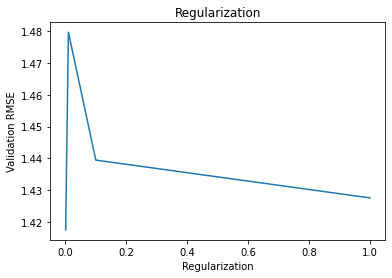

In [23]:
understanding_the_effect("Regularization")

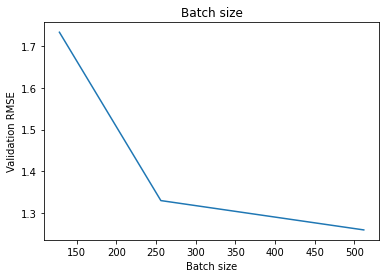

In [25]:
understanding_the_effect("Batch size")

In [43]:
# Lets fit the best model

best_ae_model = AutoEncContentModel(best_params["Layers"],
                                    epochs,
                                    int(best_params["Batch size"]),
                                    activation, dropout,
                                    float(best_params["Learning Rate"]),
                                    float(best_params["Regularization"]))

X = [ratings_train, df_users[['occupation', 'age']].values]
y = ratings_train

best_model, hist = best_ae_model.fit(X, y, verbose=2)


# # Input - We add content information for users
# X = [ratings_train, df_users[['occupation', 'age']].values]
# y = ratings_train

# # Train
# model, hist = autoenc_model.fit(X, y)


Epoch 1/10
26/26 - 1s - loss: 3.0226 - masked_rmse_loss: 1.6020 - val_loss: 1.3706 - val_masked_rmse_loss: 1.1717

Epoch 00001: val_loss improved from inf to 1.37057, saving model to weights-best-model.hdf5
Epoch 2/10
26/26 - 0s - loss: 1.1600 - masked_rmse_loss: 1.0766 - val_loss: 1.2507 - val_masked_rmse_loss: 1.1192

Epoch 00002: val_loss improved from 1.37057 to 1.25071, saving model to weights-best-model.hdf5
Epoch 3/10
26/26 - 0s - loss: 1.0824 - masked_rmse_loss: 1.0401 - val_loss: 1.1648 - val_masked_rmse_loss: 1.0806

Epoch 00003: val_loss improved from 1.25071 to 1.16479, saving model to weights-best-model.hdf5
Epoch 4/10
26/26 - 0s - loss: 1.0061 - masked_rmse_loss: 1.0026 - val_loss: 1.0844 - val_masked_rmse_loss: 1.0427

Epoch 00004: val_loss improved from 1.16479 to 1.08438, saving model to weights-best-model.hdf5
Epoch 5/10
26/26 - 0s - loss: 0.9174 - masked_rmse_loss: 0.9574 - val_loss: 0.9948 - val_masked_rmse_loss: 0.9987

Epoch 00005: val_loss improved from 1.08438 t

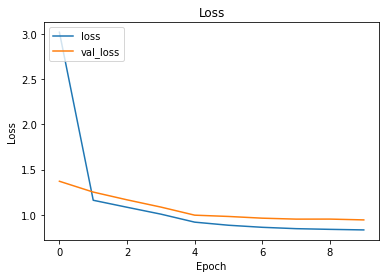

In [46]:
best_ae_model.plot_loss_history()

In [124]:
test_rmse = best_ae_model.model.evaluate(X_test, y_test)[1]
print("Model RMSE on test set:", test_rmse)

109/109 [==============================] - 0s 1ms/step - loss: 0.8970 - masked_rmse_loss: 0.9470
Model RMSE on test set: 0.9469799995422363


In [126]:
predicted_test = best_ae_model.model.predict(X_test) * (X_test == 0)
predicted_test.shape

(3459, 6040)

In [127]:
print("NDCG score:", ndcg_score(ratings_test, predicted_test))

NDCG score: 0.2794667005511281
